In [1]:
import os
import pandas as pd
import re

import ark.mibi.qc_comp as qc_comp
import ark.utils.io_utils as io_utils

### Define parameters for MIBItracker download

In [2]:
email = 'alkong@stanford.edu'
password = 'PalyVikes#2ALK'
run_name = '200929_PanCake2_CIMAC'
run_label = '200929_PanCake2_CIMAC_autotest_13'

In [3]:
base_dir = "../data"
tiff_dir = "alex_data"
img_sub_folder = None
xml_name = "sample_metadata.xml"

In [4]:
fovs = None
channels = None

### Download data off MIBItracker

In [5]:
qc_comp.download_mibitracker_data(
    email,
    password,
    run_name,
    run_label,
    base_dir,
    tiff_dir,
    xml_name,
    img_sub_folder,
    fovs,
    channels
)

Creating data for fov Point1
Creating data for fov Point2
Creating data for fov Point3
Creating data for fov Point4
Creating data for fov Point5
Creating data for fov Point6
Creating data for fov Point7
Creating data for fov Point8
Creating data for fov Point9
Creating data for fov Point10


### Define parameters for QC metric analysis

In [6]:
# define paths to the data
base_dir = "../data/erin_data"
# tiff_dir = os.path.join(base_dir, "input_data", "single_channel_inputs")
tiff_dir = base_dir

In [7]:
# define if MIBItiff images are used or not
MIBItiff = False

# data file suffix for low-level processed data
# only needed for MIBItiff = True
MIBItiff_suffix = "-MassCorrected-Filtered.tiff"

In [8]:
# define the fovs used for analysis
# either get all fovs in the folder...
if MIBItiff:
    fovs = io_utils.list_files(tiff_dir, substrs=MIBItiff_suffix)
else:
    fovs = io_utils.list_folders(tiff_dir)

# ... or optionally, select a specific set of fovs manually
# fovs = ["fov1", "fov2"]

# TODO: MIBItiff manual selection

In [9]:
# define the channels used for analysis
# if None, uses all of the channels
chans = None

In [10]:
# whether to add Gaussian blurring to the image before extracting QC metrics
gaussian_blur = False

# define the Gaussian blur sigma parameter, higher values are more aggressive removing noise
# ignored if gaussian_blur set to False
blur_factor = 1

### Create QC metric tables

In [11]:
# note: set img_sub_folder to None if there aren't any
qc_data = qc_comp.compute_qc_metrics(
    tiff_dir,
    # img_sub_folder="TIFs",
    img_sub_folder=None,
    is_mibitiff=MIBItiff,
    fovs=fovs,
    chans=chans,
    batch_size=5,
    gaussian_blur=gaussian_blur,
    blur_factor=blur_factor
)

Number of fovs processed: 5
Number of fovs processed: 10
Number of fovs processed: 15
Number of fovs processed: 20
Number of fovs processed: 25
Number of fovs processed: 30
Number of fovs processed: 35
Number of fovs processed: 40
Number of fovs processed: 45
Number of fovs processed: 50
Number of fovs processed: 55
Number of fovs processed: 60
Number of fovs processed: 65
Number of fovs processed: 70
Number of fovs processed: 75
Number of fovs processed: 80
Number of fovs processed: 85
Number of fovs processed: 90
Number of fovs processed: 95
Number of fovs processed: 100
Number of fovs processed: 105


In [12]:
df_nonzero_mean = qc_data['nonzero_mean']
df_total_intensity = qc_data['total_intensity']
df_99_9_intensity = qc_data['99_9_intensity']

In [13]:
# extract just the number from the fov name (for sorting purposes)
# NOTE: this assumes your naming scheme follows MIBI standards (ex. contains substring point{n} or fov{n})
sort_function = lambda row: sorted(re.findall(r'fov(\d+)|point(\d+)', row['fov'].lower())[0])[1]

df_nonzero_mean['fov'] = df_nonzero_mean.apply(sort_function, axis=1).astype(int)
df_total_intensity['fov'] = df_total_intensity.apply(sort_function, axis=1).astype(int)
df_99_9_intensity['fov'] = df_99_9_intensity.apply(sort_function, axis=1).astype(int)

In [14]:
# sort the data by increasing fov number (for visualization)
df_nonzero_mean = df_nonzero_mean.sort_values(by='fov')
df_total_intensity = df_total_intensity.sort_values(by='fov')
df_99_9_intensity = df_99_9_intensity.sort_values(by='fov')

In [15]:
# save the QC metric values
df_nonzero_mean.to_csv(os.path.join(base_dir, 'nonzero_mean_stats.csv'), index=False)
df_total_intensity.to_csv(os.path.join(base_dir, 'total_intensity_stats.csv'), index=False)
df_99_9_intensity.to_csv(os.path.join(base_dir, 'percentile_99_9_stats.csv'), index=False)

### Visualize QC metrics

In [16]:
# melt the DataFrames for visualization
df_nonzero_mean_melt = pd.melt(df_nonzero_mean, id_vars=['fov'], value_vars=chans, var_name='channel', value_name='Non-zero mean intensity')
df_total_intensity_melt = pd.melt(df_total_intensity, id_vars=['fov'], value_vars=chans, var_name='channel', value_name='Total intensity')
df_99_9_intensity_melt = pd.melt(df_99_9_intensity, id_vars=['fov'], value_vars=chans, var_name='channel', value_name='99.9% intensity value')

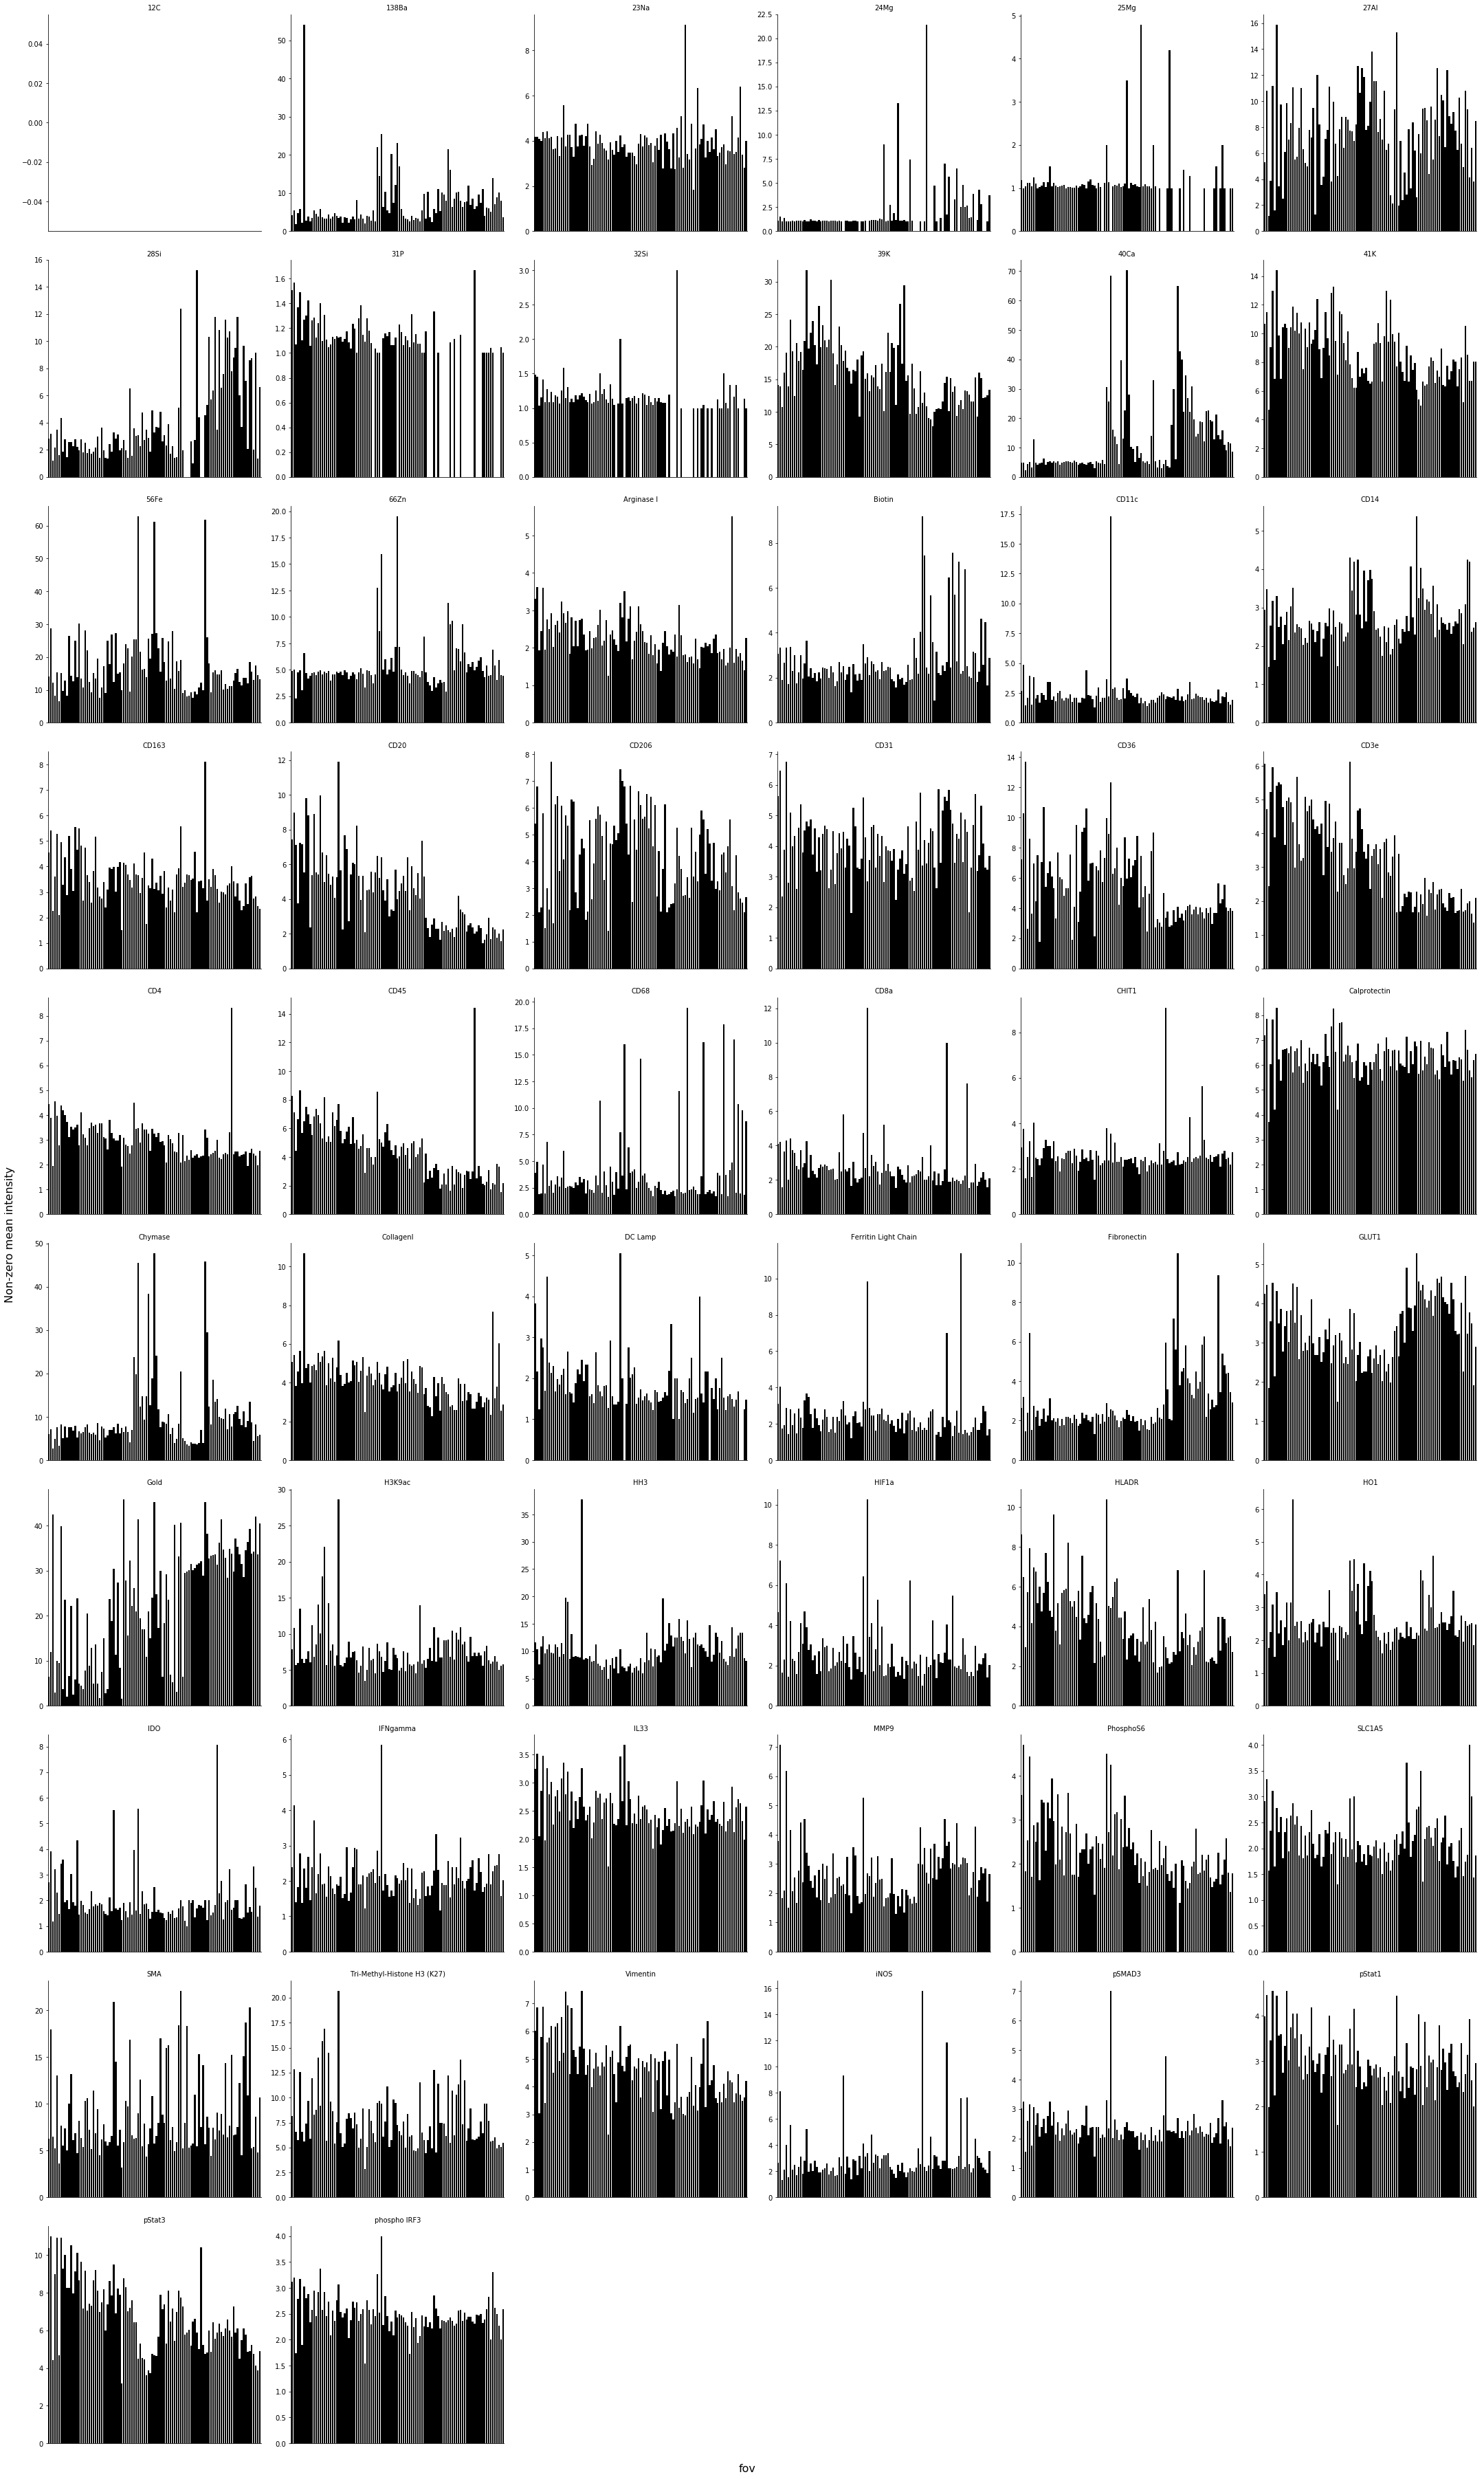

In [17]:
# visualize the non-zero mean intensity stats
qc_comp.visualize_qc_metrics(
    df_nonzero_mean_melt,
    'Non-zero mean intensity',
    axes_size=16,
    wrap=6,
    dpi=None,
    save_dir=None
)

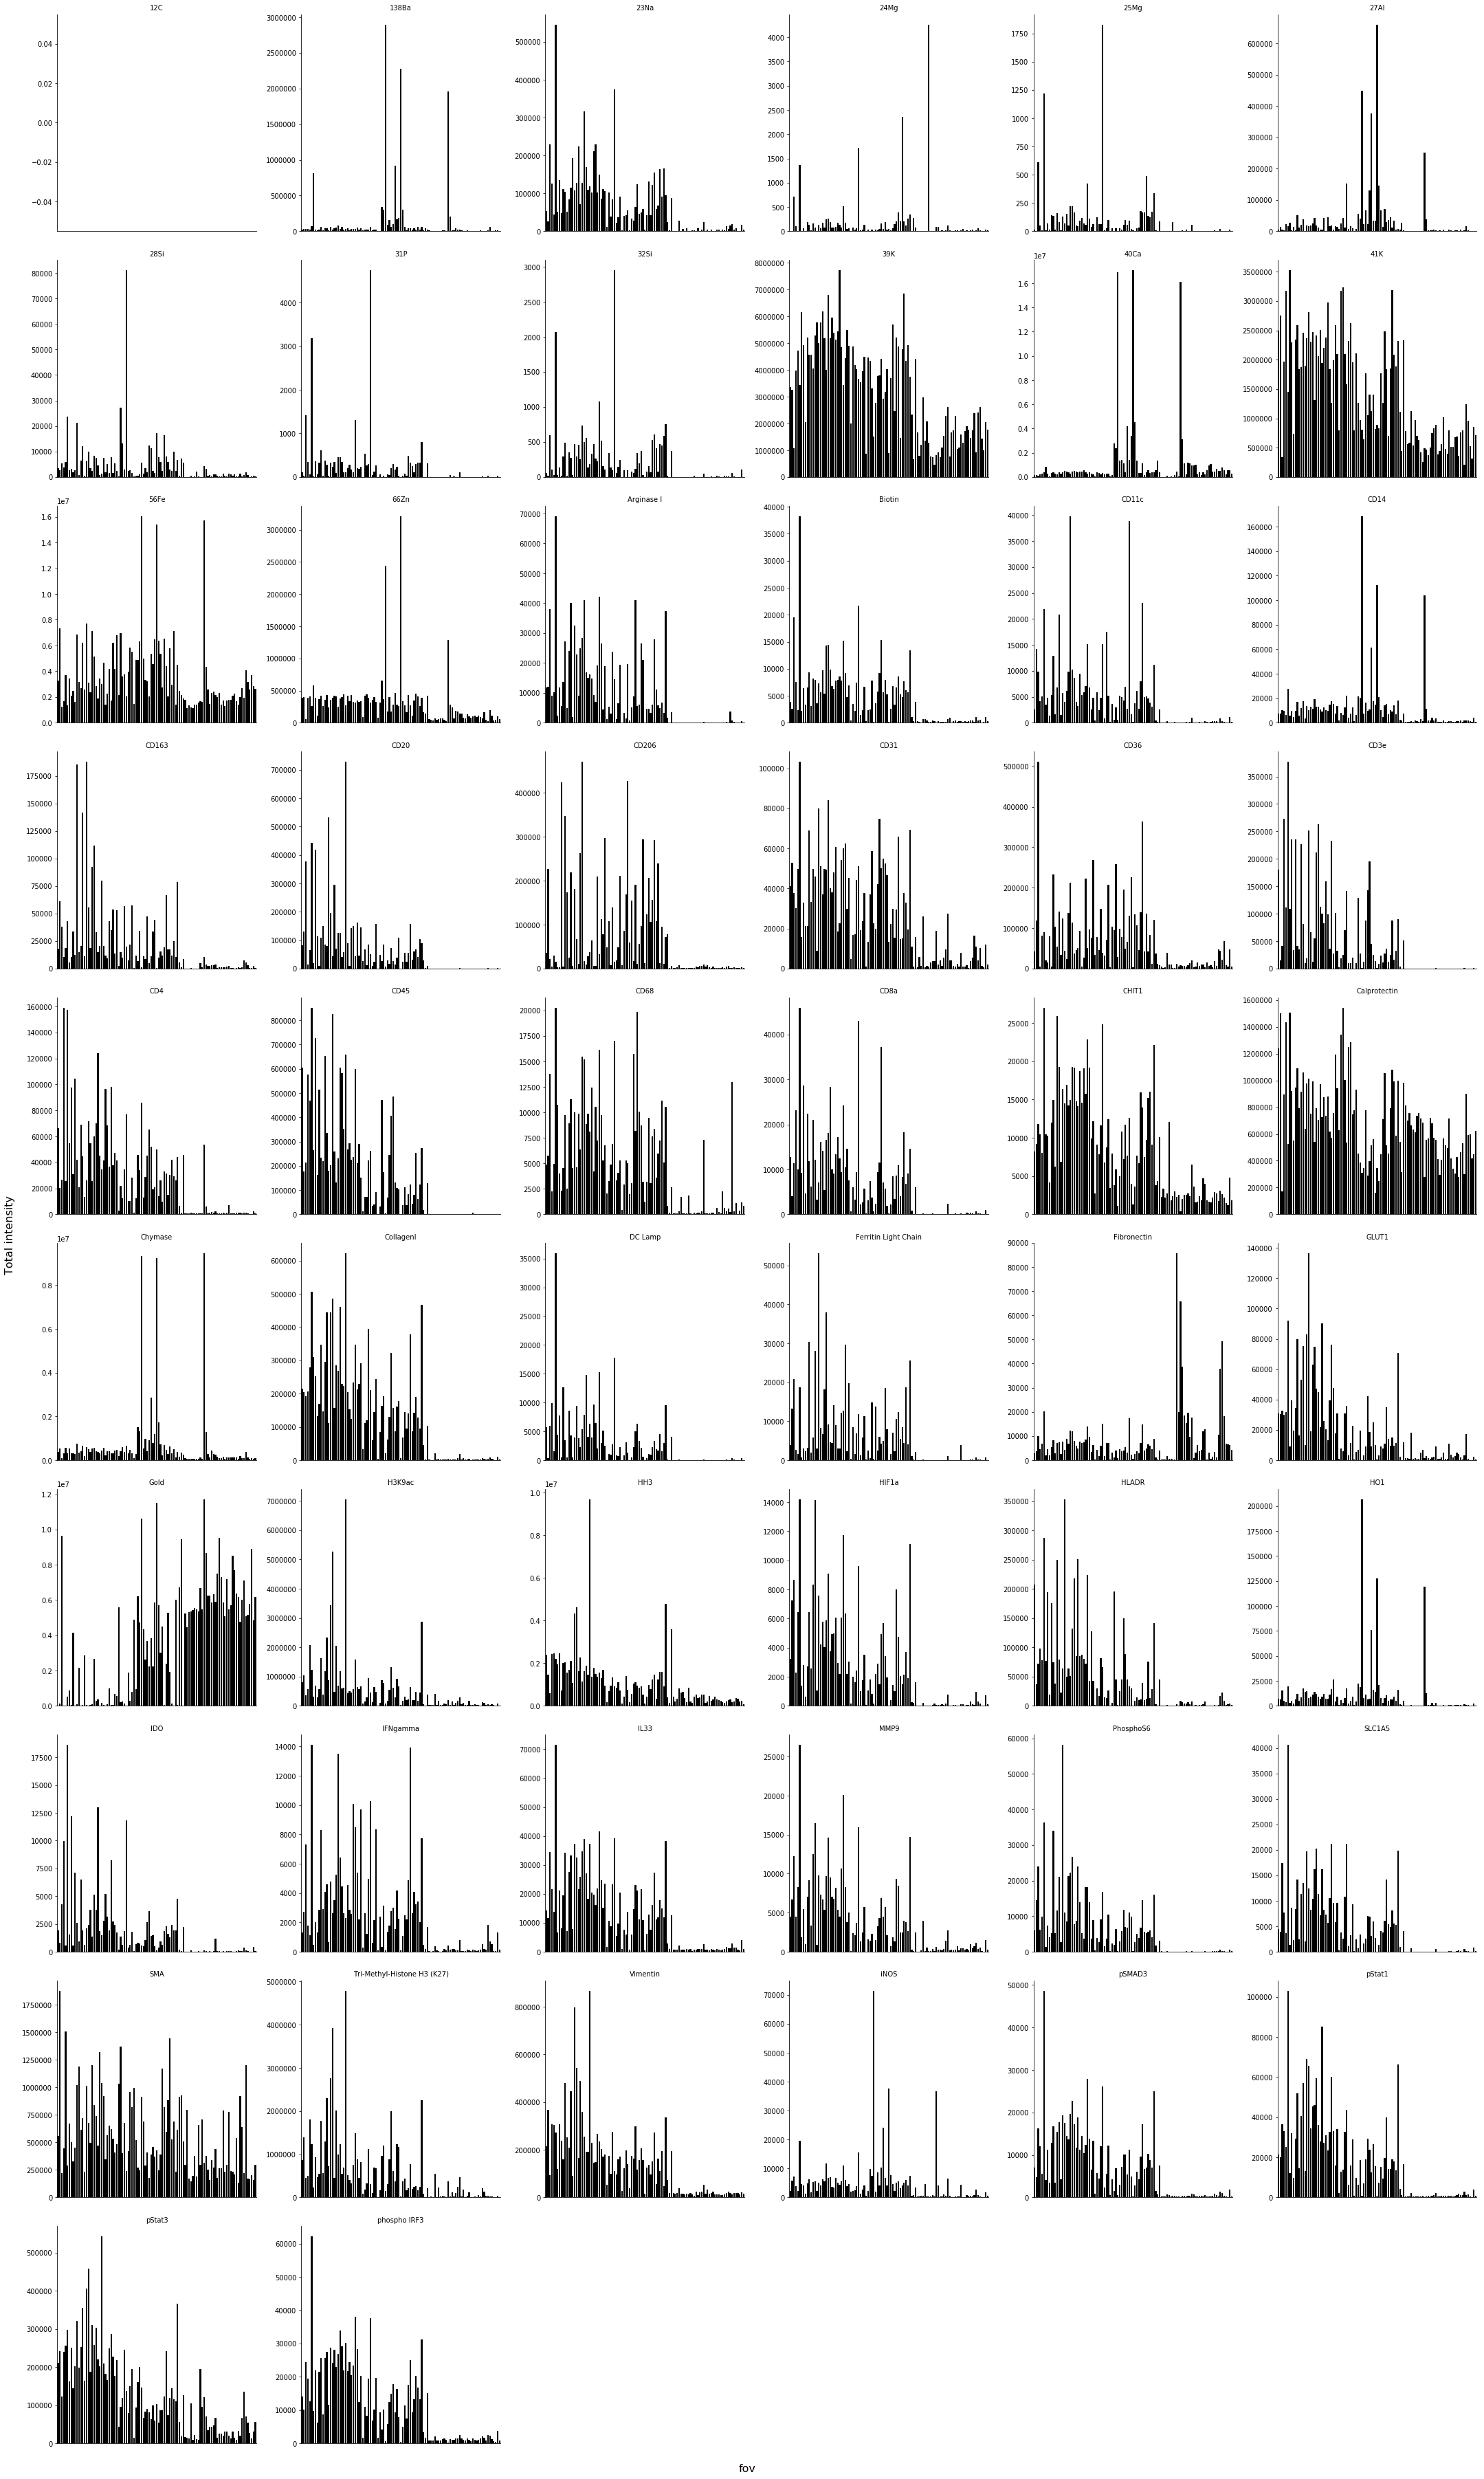

In [18]:
# visualize the total intensity stats
qc_comp.visualize_qc_metrics(
    df_total_intensity_melt,
    'Total intensity',
    axes_size=16,
    wrap=6,
    dpi=None,
    save_dir=None
)

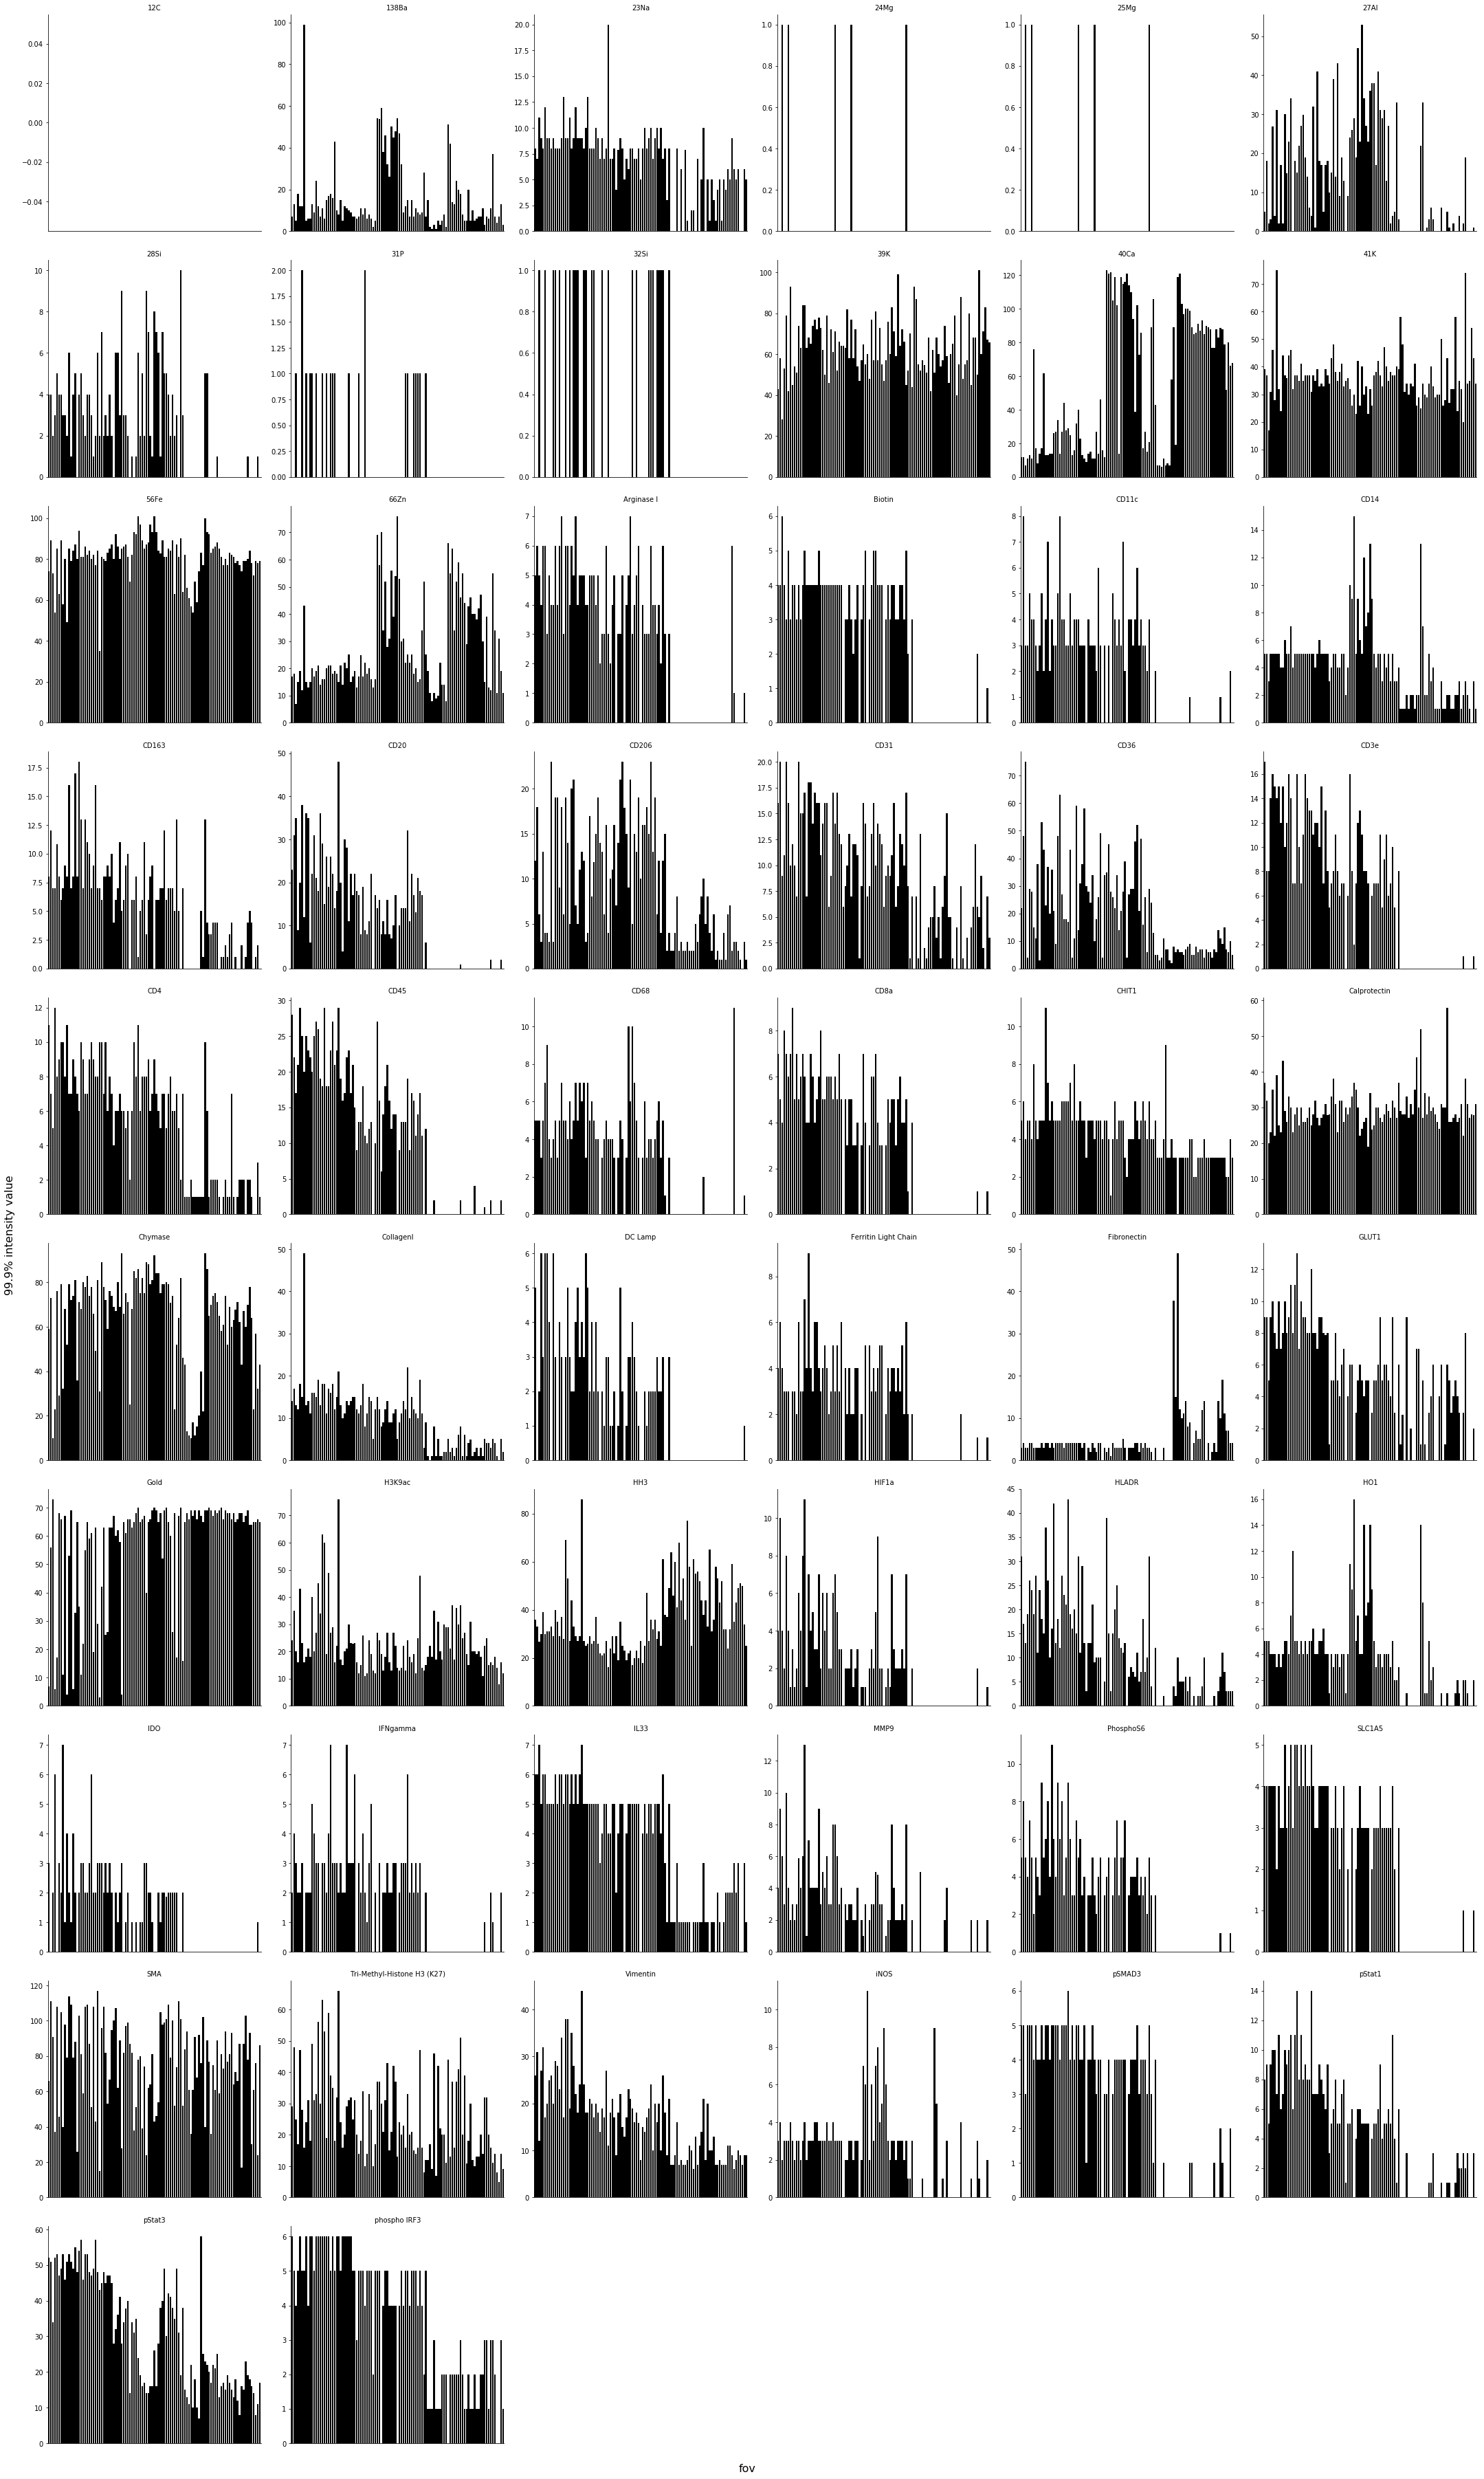

In [19]:
# visualize the 99.9% intensity value stats
qc_comp.visualize_qc_metrics(
    df_99_9_intensity_melt,
    '99.9% intensity value',
    axes_size=16,
    wrap=6,
    dpi=None,
    save_dir=None
)